In [1]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from IPython import display 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
env = gym.make("CartPole-v0")

In [4]:
env.observation_space

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)

In [5]:
env.action_space.n

2

### The algorithm

1. Initialize replay memory capacity.
2. Initialize the policy network with random weights.
3. Clone the policy network, and call it the target network.
4.  For each episode:
    1. Initialize the starting state.
    2. For each time step:
        1. Select an action.
            * Via exploration or exploitation
        2. Execute selected action in an emulator.
        3. Observe reward and next state.
        4. Store experience in replay memory.
        5. Sample random batch from replay memory.
        6. Preprocess states from batch.
        7. Pass batch of preprocessed states to policy network.
        8. Calculate loss between output Q-values and target Q-values.
           * Requires a pass to the target network for the next state
        9. Gradient descent updates weights in the policy network to minimize loss.
            * After  time steps, weights in the target network are updated to the weights in the policy network.

### Deep Q-Neetwork

In [6]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super(DQN, self).__init__()
        
        self.fc1 = nn.Linear(in_features = img_height*img_width*3, out_features = 24)
        self.fc2 = nn.Linear(in_features = 24, out_features = 32)
        self.fc3 = nn.Linear(in_features = 32, out_features = 2)
        self.flat = nn.Flatten()
        
    def forward(self, x):
        x = self.flat(x) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Experience Class

In [7]:
Experience = namedtuple(
    "Experience", ("state", "action", "next_state", "reward")
)

In [8]:
e = Experience(2, 3, 1, 4)

In [9]:
e

Experience(state=2, action=3, next_state=1, reward=4)

### Replay Memory

In [10]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else: # replace from the beginning of the buffer
            self.memory[self.push_count%self.capacity] = experience
        self.push_count += 1
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

### Epsilon Greedy Strategy

In [11]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

### RL Agent

In [12]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        
    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1
        
        if rate > random.random():
            action = random.randrange(self.num_actions)
            return  torch.tensor([action]).to(self.device) # exploration
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim = 1).to(self.device) # exploitation

### Environment Manager

In [13]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device 
        self.env = gym.make("CartPole-v0").unwrapped # unwrapped gives us access to the behind the scenes dynamics of the environment
        self.env.reset()
        self.current_screen = None # track the screen (render) of the environment. When None, we are at the beginning of the episode 
        self.done = False # episode's state
        
    def reset(self):
        self.env.reset()
        self.current_screen = None
    
    def close(self):
        self.env.close()
    
    def render(self, mode = "human"):
        return self.env.render(mode) # render the current state to the screen
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self, action):
        _, reward, self.done, info = self.env.step(action.item())
        return torch.tensor([reward], device = self.device)
    
    def just_starting(self):
        return self.current_screen is None # if True starting state
    
    def get_state(self):
        if self.just_starting() or self.done: # starting or ending of an episode
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render("rgb_array").transpose((2,0,1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        
        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype = np.float32)/255
        screen = torch.from_numpy(screen)
        
        resize = T.Compose([
            T.ToPILImage(),
            T.Resize((40,90)),
            T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device)

Example - Non Processed

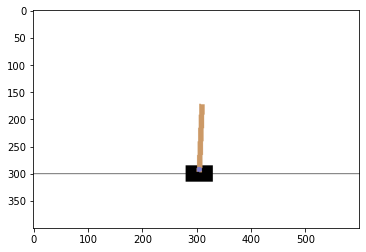

In [14]:
em = CartPoleEnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.imshow(screen);
em.close()

Example Processed

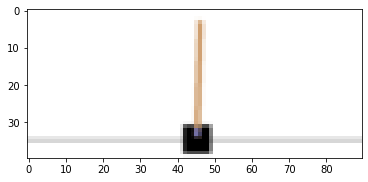

In [15]:
screen = em.get_processed_screen().to('cpu')
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation = "none");

In [16]:
em.close()

Example of starting state

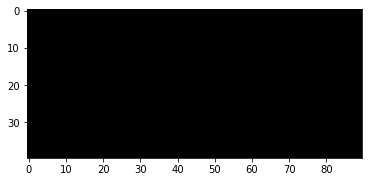

In [17]:
screen = em.get_state().to("cpu")
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation = "none");

In [18]:
em.close()

Example of non staring state

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


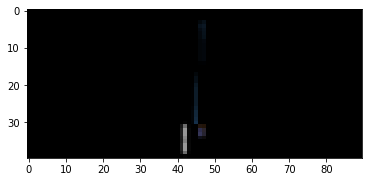

In [19]:
for i in range(5):
    em.take_action(torch.tensor([1]))

screen = em.get_state().to("cpu")
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation = "none");

In [20]:
em.close()

Example of end state

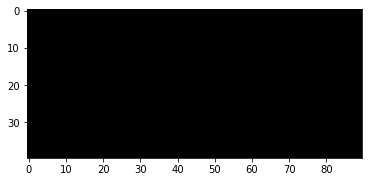

In [21]:
em.done = True
screen = em.get_state().to("cpu")

plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation = "none")

In [22]:
em.close()

### Utility Functions

In [23]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title("Training...")
    plt.xlabel("# Episode")
    plt.ylabel("Duration")
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values), "\n", moving_avg_period, "episode moving avg:", moving_avg[-1])
    display.clear_output(wait = True)

In [24]:
def get_moving_average(period, values):
    values = torch.tensor(values, dtype = torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension = 0, size = period, step = 1).mean(dim = 1).flatten(start_dim = 0)
        moving_avg = torch.cat((torch.zeros(period - 1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

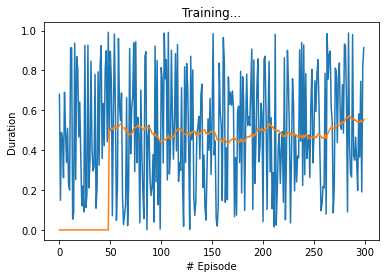

Episode 300 
 50 episode moving avg: 0.55444014


In [25]:
plot(np.random.rand(300),50)

### Main Program

In [26]:
batch_size = 512
gamma = 0.99
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memrory_size = 100000
lr = 0.001
num_episodes = 300

In [27]:
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memrory_size)

In [28]:
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

In [29]:
em.close()

In [30]:
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (fc1): Linear(in_features=10800, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [31]:
optimizer = optim.Adam(params = policy_net.parameters(), lr = lr)

Tensor Processing

In [32]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    return (t1,t2,t3,t4)

Q-Value Calculator

In [33]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim = 1, index=actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim = 1).max(dim = 1)[0].eq(0).type(torch.bool)# terminal states where the screen is black (max == 0)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim = 1)[0].detach()
        return values

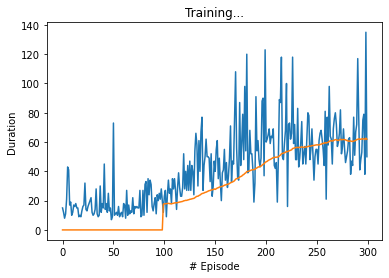

Episode 300 
 100 episode moving avg: 61.94


In [34]:
episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
            
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
em.close()